In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')

In [2]:
def readh5files(arx): 
#    print('DATA FROM FILE:      ',arx)

    with h5py.File(arx, "r") as f:
      # List all groups
     #   print("Keys: %s" % f.keys())
        a_group_key = list(f.keys())

        Sf = np.array(f.get('S_f'))
        x = np.array(f.get('x'))
        y = np.array(f.get('y'))
        z = np.array(f.get('z'))
        xf = np.array(f.get('x_f'))
        yf = np.array(f.get('y_f'))
        zf = np.array(f.get('z_f'))
        rho = np.array(f.get('rho_mean'))
        Mxx = np.array(f.get('stress_Mxx'))
        Mxy = np.array(f.get('stress_Mxy'))
        Mxz = np.array(f.get('stress_Mxz'))
        Myy = np.array(f.get('stress_Myy'))
        Myz = np.array(f.get('stress_Myz'))
        Mzz = np.array(f.get('stress_Mzz'))
        Rxx = np.array(f.get('stress_Rxx'))
        Rxy = np.array(f.get('stress_Rxy'))
        Rxz = np.array(f.get('stress_Rxz'))
        Ryy = np.array(f.get('stress_Ryy'))
        Ryz = np.array(f.get('stress_Ryz'))
        Rzz = np.array(f.get('stress_Rzz'))
        Fxx = np.array(f.get('stress_Fxx'))
        Fxy = np.array(f.get('stress_Fxy'))
        Fxz = np.array(f.get('stress_Fxz'))
        Fyx = np.array(f.get('stress_Fyx'))
        Fyy = np.array(f.get('stress_Fyy'))
        Fyz = np.array(f.get('stress_Fyz'))
        Fzx = np.array(f.get('stress_Fzx'))
        Fzy = np.array(f.get('stress_Fzy'))
        Fzz = np.array(f.get('stress_Fzz'))

        time = np.array(f.get('time'))

        f.close()
  
    M = np.array([Mxx,Mxy,Mxz,Myy,Myz,Mzz])
    R = np.array([Rxx,Rxy,Rxz,Ryy,Ryz,Rzz])
    F = np.array([Fyx-Fxy,Fzx-Fxz,Fzy-Fyz])
  
#    print('Dimensions of the grid     :',len(x)," x ",len(y)," x ",len(z))
    print('Time           :',time)
  
    return [M, R, F, rho, x, y, z, xf, yf, zf]

In [3]:
def energy_dens(Rtensor,rho):
     
    traceR = Rtensor[:,0,:,:,:]+Rtensor[:,3,:,:,:]+Rtensor[:,5,:,:,:]
    energyR = 0.5*rho*traceR

    return energyR

def error_propagation(rho,err_rho,M,err_M,R,err_R,F,err_F,lent):
    
    traceR = R[0]+R[3]+R[5]
    e_alphaR = np.zeros((6,lent))
    e_betaR = np.zeros((6,lent))
    e_gammaR = np.zeros((3,lent))

    for i in range(0,6):
        e_alphaR[i,:] = (err_M[i,:]/(0.5*rho[:]*traceR[:])**2+(M[i,:]/(0.5*traceR[:]*rho[:]**2))**2*err_rho[:]+(M[i,:]/(0.5*rho[:]*traceR[:]**2))**2*(err_R[0,:]+err_R[3,:]+err_R[5,:]))**(0.5)
        if i == 1 or i == 2 or i == 4: 
            e_betaR[i,:] = (err_R[i,:]/(0.5*traceR[:])**2+(R[i,:]/(0.5*traceR[:]**2))**2*(err_R[0,:]+err_R[3,:]+err_R[5,:]))**(0.5)
        elif i == 0:
            e_betaR[i,:] = (err_R[i,:]*(1/0.5*(1/traceR[:]-R[i,:]/traceR[:]**2))**2+(R[i,:]/(0.5*traceR[:]))**2*(err_R[3,:]+err_R[5,:]))**(0.5)
        elif i == 3:
            e_betaR[i,:] = (err_R[i,:]*(1/0.5*(1/traceR[:]-R[i,:]/traceR[:]**2))**2+(R[i,:]/(0.5*traceR[:]))**2*(err_R[0,:]+err_R[5,:]))**(0.5)
        elif i == 5:
            e_betaR[i,:] = (err_R[i,:]*(1/0.5*(1/traceR[:]-R[i,:]/traceR[:]**2))**2+(R[i,:]/(0.5*traceR[:]))**2*(err_R[3,:]+err_R[0,:]))**(0.5)
    for j in range(0,3):        
        e_gammaR[j] = (err_F[j,:]/(0.5*rho[:]**(0.5)*traceR[:])**2+(F[j,:]/(0.25*rho[:]**(-1.5)*traceR[:]))**2*err_rho[:]+(F[j,:]/(0.5*rho[:]**(0.5)*traceR[:]**2))**2*(err_R[0,:]+err_R[3,:]+err_R[5,:]))**(0.5)
    
    return e_alphaR, e_betaR, e_gammaR

In [4]:
bx0 = '3e-4'
leng = 512
res = str(leng)+'_'+str(leng)+'_'+str(leng)
Sf = '80'
path = "/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/DATA/KHI/res_"+res+"/CVP--bx"+bx0+"--"+str(leng)+"--rndom"

In [5]:
ind_ini = 100
ind_fin = 201
told = np.linspace(0,40,201)
#told = told[:-1]
#t = told[1:]
tsat = told[ind_ini:ind_fin]
lent = len(tsat)

    
#stress tensors:

Msim = np.zeros((lent,6,15,2,15))
Rsim = np.zeros((lent,6,15,2,15))
Fsim = np.zeros((lent,3,15,2,15))
rhomean = np.zeros((lent,15,2,15))

inivars = readh5files(path+'/stress_tensors_filt/Sf_'+Sf+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+Sf+'-0000.h5')
#inivars = readh5files(path+'/results/stress_tensors/Sf_'+Sf+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+Sf+'-0000.h5')

xfilter = inivars[7]
yfilter = inivars[8]
zfilter = inivars[9]
    
    
for tt in range(0, lent):        
    arx = format(int(10*tsat[tt]), "04")
    Msim[tt], Rsim[tt], Fsim[tt], rhomean[tt], x, y, z, xfilter, yfilter, zfilter = readh5files(path+'/stress_tensors_filt/Sf_'+Sf+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+Sf+'-'+arx+'.h5')
#    Msim[tt], Rsim[tt], Fsim[tt], rhomean[tt], x, y, z, xfilter, yfilter, zfilter = readh5files(path+'/results/stress_tensors/Sf_'+Sf+'/stresses--'+str(leng)+'--bx'+bx0+'--Sf-'+Sf+'-'+arx+'.h5')


energyR = energy_dens(Rsim,rhomean)
        
    #constants:

alpha = []
beta = []
gamma = []

for i in range(0,6):
    alpha.append(Msim[:,i]/energyR)
    beta.append(rhomean[:]*Rsim[:,i]/energyR)

for i in range(0,3):
    gamma.append((rhomean[:])**(0.5)*Fsim[:,i]/energyR)

alpha = np.array(alpha)
beta = np.array(beta)
gamma = np.array(gamma)

#averages: 
            
alpha_av = np.mean(alpha, axis =(2,3,4))
beta_av = np.mean(beta, axis =(2,3,4))
gamma_av = np.mean(gamma, axis =(2,3,4))

e_alpha = np.std(alpha,  axis =(2,3,4))
e_beta = np.std(beta,  axis =(2,3,4))
e_gamma = np.std(gamma,  axis =(2,3,4))

alphat = np.mean(alpha_av, axis = 1)
betat = np.mean(beta_av, axis = 1)
gammat = np.mean(gamma_av, axis = 1)
          
err_av_alpha = (1/np.sum(1/e_alpha**2,axis = 1))**(0.5)
err_av_beta = (1/np.sum(1/e_beta**2,axis = 1))**(0.5)
err_av_gamma = (1/np.sum(1/e_gamma**2,axis = 1))**(0.5)
          
etot_alpha = np.sqrt(np.std(alpha_av, axis = 1)**2+err_av_alpha**2)
etot_beta = np.sqrt(np.std(beta_av, axis = 1)**2+err_av_beta**2)
etot_gamma = np.sqrt(np.std(gamma_av, axis = 1)**2+err_av_gamma**2)

Time           : 0.0
Time           : 20.0
Time           : 20.200000000000003
Time           : 20.400000000000002
Time           : 20.6
Time           : 20.8
Time           : 21.0
Time           : 21.200000000000003
Time           : 21.400000000000002
Time           : 21.6
Time           : 21.8
Time           : 22.0
Time           : 22.200000000000003
Time           : 22.400000000000002
Time           : 22.6
Time           : 22.8
Time           : 23.0
Time           : 23.200000000000003
Time           : 23.400000000000002
Time           : 23.6
Time           : 23.8
Time           : 24.0
Time           : 24.200000000000003
Time           : 24.400000000000002
Time           : 24.6
Time           : 24.8
Time           : 25.0
Time           : 25.200000000000003
Time           : 25.400000000000002
Time           : 25.6
Time           : 25.8
Time           : 26.0
Time           : 26.200000000000003
Time           : 26.400000000000002
Time           : 26.6
Time           : 26.8
Time         

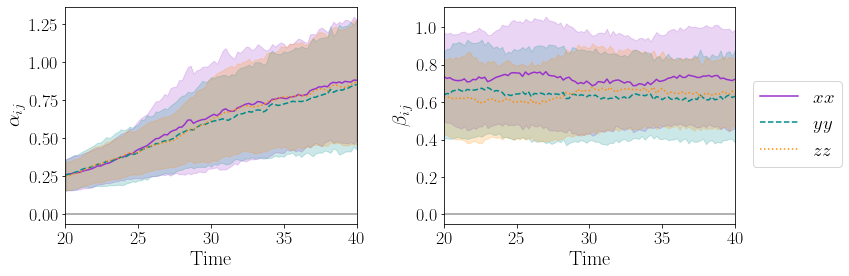

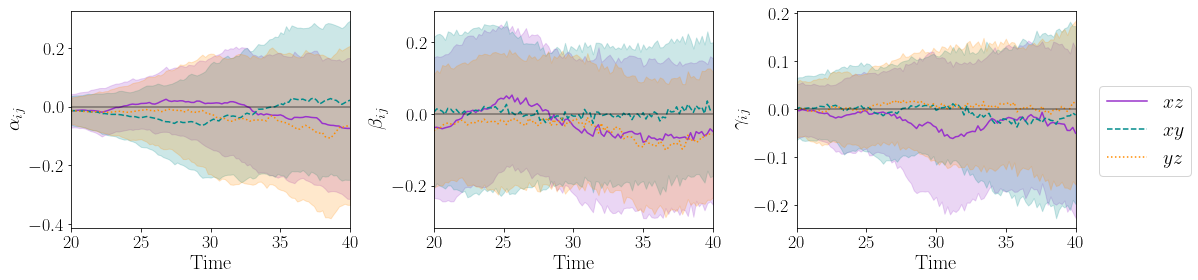

In [6]:
fig, axs = plt.subplots(1,2,sharex = 'all',sharey = False, figsize = (12,4))
plt.subplots_adjust(hspace = 0.1,wspace = 0.3)

ax1 = axs[0]
ax3 = axs[1]

t = tsat
    
ax1.tick_params(axis='x',labelsize = 18)   
ax3.tick_params(axis='x',labelsize = 18)
ax1.tick_params(axis='y',labelsize = 18)
ax3.tick_params(axis='y',labelsize = 18)
        
ax1.plot(t[:], alpha_av[0,:], linestyle = 'solid', color = 'darkorchid', label = r'$\alpha_{\rm{R},xx}$')
ax1.fill_between(t[:], alpha_av[0,:]-e_alpha[0,:], alpha_av[0,:]+e_alpha[0,:], color = 'darkorchid', alpha = 0.2)
ax1.plot(t[:], alpha_av[3,:], linestyle = 'dashed' , color = 'darkcyan', label = r'$\alpha_{\rm{R},yy}$')
ax1.fill_between(t[:], alpha_av[3,:]-e_alpha[3,:], alpha_av[3,:]+e_alpha[3,:], color='darkcyan', alpha = 0.2)
ax1.plot(t[:], alpha_av[5,:], linestyle = 'dotted', color = 'darkorange', label = r'$\alpha_{\rm{R},zz}$')
ax1.fill_between(t[:], alpha_av[5,:]-e_alpha[5,:], alpha_av[5,:]+e_alpha[5,:], color='darkorange', alpha = 0.2)
ax1.set_xlabel('Time', fontsize = 20)
ax1.set_ylabel(r'$\alpha_{ij}$', fontsize = 20)
ax1.hlines(y = 0, xmin = t[0], xmax = t[-1], linestyle = 'solid', color = 'black', alpha = 0.4 )
#ax1.set_yscale('log')
#ax1.axvline(11,color='grey',linestyle='dashed',linewidth=1.5)
ax1.set_xlim([20,40])
    
ax3.plot(t, beta_av[0,:], linestyle = 'solid', color = 'darkorchid', label = r'$xx$')
ax3.fill_between(t, beta_av[0,:]-e_beta[0,:], beta_av[0,:]+e_beta[0,:], color = 'darkorchid', alpha = 0.2)
ax3.plot(t, beta_av[3,:], linestyle = 'dashed' , color = 'darkcyan', label = r'$yy$')
ax3.fill_between(t, beta_av[3,:]-e_beta[3,:], beta_av[3,:]+e_beta[3,:], color='darkcyan', alpha = 0.2)
ax3.plot(t, beta_av[5,:], linestyle = 'dotted', color = 'darkorange', label = r'$zz$')
ax3.fill_between(t, beta_av[5,:]-e_beta[5,:], beta_av[5,:]+e_beta[5,:], color='darkorange', alpha = 0.2)
ax3.set_xlabel('Time', fontsize = 20)
ax3.set_ylabel(r'$\beta_{ij}$', fontsize = 20)
ax3.hlines(y = 0, xmin = t[0], xmax = t[-1], linestyle = 'solid', color = 'black', alpha = 0.4 )
ax3.legend(bbox_to_anchor=(1.4,0.7), ncol = 1, frameon = 'True',prop={"size":19})
#ax3.axvline(11,color='grey',linestyle='dashed',linewidth=1.5)
plt.savefig('/home/miquelmiravet/Desktop/figs_khi/diag-coeffs_KHI-H1--late.pdf',bbox_inches='tight')

   
fig, ax = plt.subplots(1,3,sharex = 'all',sharey = False, figsize = (18,4))
plt.subplots_adjust(hspace = 0.1,wspace = 0.3)
    
ax2 = ax[0]
ax4 = ax[1]
ax5 = ax[2]
    
ax5.tick_params(axis='x',labelsize = 18)
ax2.tick_params(axis='x',labelsize = 18)
ax4.tick_params(axis='x',labelsize = 18)
ax2.tick_params(axis='y',labelsize = 18)
ax4.tick_params(axis='y',labelsize = 18)
ax5.tick_params(axis='y',labelsize = 18)

ax5.plot(t, gamma_av[1,:], linestyle = 'solid', color = 'darkorchid', label = r'$xz$')
ax5.fill_between(t, gamma_av[1,:]-e_gamma[1,:], gamma_av[1,:]+e_gamma[1,:], color='darkorchid', alpha = 0.2)
ax5.plot(t, gamma_av[0,:], linestyle = 'dashed', color = 'darkcyan', label = r'$xy$')
ax5.fill_between(t, gamma_av[0,:]-e_gamma[0,:], gamma_av[0,:]+e_gamma[0,:], color = 'darkcyan', alpha = 0.2)
ax5.plot(t, gamma_av[2,:], linestyle = 'dotted', color = 'darkorange', label = r'$yz$')
ax5.fill_between(t, gamma_av[2,:]-e_gamma[2,:], gamma_av[2,:]+e_gamma[2,:], color='darkorange', alpha = 0.2)
#ax5.axvline(11,color='grey',linestyle='dashed',linewidth=1.5)

ax2.plot(t, alpha_av[2,:], linestyle = 'solid', color = 'darkorchid', label = r'$\alpha_{\rm{R},xz}$')
ax2.fill_between(t, alpha_av[2,:]-e_alpha[2,:], alpha_av[2,:]+e_alpha[2,:], color='darkorchid', alpha = 0.2)
ax2.plot(t, alpha_av[1,:], linestyle = 'dashed', color = 'darkcyan', label = r'$\alpha_{\rm{R},xy}$')
ax2.fill_between(t, alpha_av[1,:]-e_alpha[1,:], alpha_av[1,:]+e_alpha[1,:], color='darkcyan', alpha = 0.2)
ax2.plot(t, alpha_av[4,:], linestyle = 'dotted', color = 'darkorange', label = r'$\alpha_{\rm{R},yz}$')
ax2.fill_between(t, alpha_av[4,:]-e_alpha[4,:], alpha_av[4,:]+e_alpha[4,:], color='darkorange', alpha = 0.2)
#ax2.axvline(11,color='grey',linestyle='dashed',linewidth=1.5)

#ax2.set_ylim([-2,-2.5])
    
ax4.plot(t, beta_av[2,:], linestyle = 'solid', color = 'darkorchid', label = r'$\beta_{\rm{R},rxz}$')
ax4.fill_between(t, beta_av[2,:]-e_beta[2,:], beta_av[2,:]+e_beta[2,:], color='darkorchid', alpha = 0.2)
ax4.plot(t, beta_av[1,:], linestyle = 'dashed', color = 'darkcyan', label = r'$\beta_{\rm{R},xy}$')
ax4.fill_between(t, beta_av[1,:]-e_beta[1,:], beta_av[1,:]+e_beta[1,:], color='darkcyan', alpha = 0.2)
ax4.plot(t, beta_av[4,:], linestyle = 'dotted', color = 'darkorange', label = r'$\beta_{\rm{R},yz}$')
ax4.fill_between(t, beta_av[4,:]-e_beta[4,:], beta_av[4,:]+e_beta[4,:], color='darkorange', alpha = 0.2)
#ax4.axvline(11,color='grey',linestyle='dashed',linewidth=1.5)

ax2.set_xlabel('Time', fontsize = 20)
ax2.set_ylabel(r'$\alpha_{ij}$', fontsize = 20)
ax2.set_xlim((20,40))
ax2.hlines(y = 0, xmin = t[0], xmax = t[-1], linestyle = 'solid', color = 'black', alpha = 0.4 )
ax4.set_xlabel('Time', fontsize = 20)
ax4.set_ylabel(r'$\beta_{ij}$', fontsize = 20)
#ax2.set_ylim((2,-1))
ax4.hlines(y = 0, xmin = t[0], xmax = t[-1], linestyle = 'solid', color = 'black', alpha = 0.4 )
ax5.set_xlabel('Time', fontsize = 20)
ax5.set_ylabel(r'$\gamma_{ij}$',fontsize = 20)
ax5.hlines(y = 0, xmin = t[0], xmax = t[-1], linestyle = 'solid', color = 'black', alpha = 0.4 )
#plt.yscale('symlog')
ax5.legend(bbox_to_anchor=(1.45,0.7), ncol = 1, frameon = 'True',prop={"size":20})

plt.savefig('/home/miquelmiravet/Desktop/figs_khi/non-diag-coeffs_KHI-H1--late.pdf',bbox_inches='tight')

In [76]:
coord = ['xx','xy','xz','yy','yz','zz']

for i in range(0,6):
    print('alpha_ %s = %.6f +- %.6f'%(coord[i],alphat[i],etot_alpha[i]))
print('*'*60)
for i in range(0,6):
    print('beta_ %s = %.6f +- %.6f'%(coord[i],betat[i],etot_beta[i]))
print('*'*60)

coord2 =['xy','xz','yz']
    
for i in range(0,3):
    print('gamma_ %s = %.6f +- %.6f'%(coord2[i],gammat[i],etot_gamma[i]))
print('*'*60) 

alpha_ xx = 0.163106 +- 0.153676
alpha_ xy = -0.000302 +- 0.006953
alpha_ xz = -0.003892 +- 0.006773
alpha_ yy = 0.143316 +- 0.132952
alpha_ yz = 0.003754 +- 0.008026
alpha_ zz = 0.159700 +- 0.147477
************************************************************
beta_ xx = 0.835638 +- 0.244457
beta_ xy = 0.001824 +- 0.020120
beta_ xz = -0.026050 +- 0.028420
beta_ yy = 0.545736 +- 0.122618
beta_ yz = 0.011026 +- 0.011935
beta_ zz = 0.618626 +- 0.126080
************************************************************
gamma_ xy = 0.002941 +- 0.006581
gamma_ xz = 0.001752 +- 0.009863
gamma_ yz = 0.000877 +- 0.004282
************************************************************


In [14]:
path = '/home/miquelmiravet/University/Doctorat/Projects/sub-grid_models/pablo-model/results/coefficients_r0/coeffs-KHI-512--t-20/'
alphablow = np.loadtxt(path+'alpha-bx--3e-4.txt')
betablow = np.loadtxt(path+'beta-bx--3e-4.txt')
gammablow = np.loadtxt(path+'gamma-bx--3e-4.txt')
salphablow = np.loadtxt(path+'sigma-alpha-bx--3e-4.txt')
sbetablow = np.loadtxt(path+'sigma-beta-bx--3e-4.txt')
sgammablow = np.loadtxt(path+'sigma-gamma-bx--3e-4.txt')
alphabmid = np.loadtxt(path+'alpha-bx--1e-3.txt')
betabmid = np.loadtxt(path+'beta-bx--1e-3.txt')
gammabmid = np.loadtxt(path+'gamma-bx--1e-3.txt')
salphabmid = np.loadtxt(path+'sigma-alpha-bx--1e-3.txt')
sbetabmid = np.loadtxt(path+'sigma-beta-bx--1e-3.txt')
sgammabmid = np.loadtxt(path+'sigma-gamma-bx--1e-3.txt')

alpha = (alphablow/salphablow+alphabmid/salphabmid)/(1/salphablow+1/salphabmid)
beta = (betablow/sbetablow+betabmid/sbetabmid)/(1/sbetablow+1/sbetabmid)
gamma = (gammablow/sgammablow+gammabmid/sgammabmid)/(1/sgammablow+1/sgammabmid)

salpha = np.sqrt((salphablow**2+salphabmid**2)/2)
sbeta = np.sqrt((sbetablow**2+sbetabmid**2)/2)
sgamma = np.sqrt((sgammablow**2+sgammabmid**2)/2)

In [15]:
coord = ['xx','xy','xz','yy','yz','zz']

for i in range(0,6):
    print('alpha_ %s = %.6f +- %.6f'%(coord[i],alpha[i],salpha[i]))
print('*'*60)
for i in range(0,6):
    print('beta_ %s = %.6f +- %.6f'%(coord[i],beta[i],sbeta[i]))
print('*'*60)

coord2 =['xy','xz','yz']
    
for i in range(0,3):
    print('gamma_ %s = %.6f +- %.6f'%(coord2[i],gamma[i],sgamma[i]))
print('*'*60) 

alpha_ xx = 0.720000 +- 0.254951
alpha_ xy = -0.009910 +- 0.033801
alpha_ xz = -0.020339 +- 0.029504
alpha_ yy = 0.640000 +- 0.180000
alpha_ yz = -0.026200 +- 0.025495
alpha_ zz = 0.646216 +- 0.185068
************************************************************
beta_ xx = 0.743333 +- 0.047434
beta_ xy = -0.007547 +- 0.026730
beta_ xz = -0.041429 +- 0.035355
beta_ yy = 0.640000 +- 0.025495
beta_ yz = -0.018644 +- 0.029504
beta_ zz = 0.613750 +- 0.041231
************************************************************
gamma_ xy = -0.009667 +- 0.018111
gamma_ xz = -0.010816 +- 0.025110
gamma_ yz = -0.008310 +- 0.014714
************************************************************
